<a href="https://colab.research.google.com/github/jshogland/SpatialModelingTutorials/blob/main/Notebooks/kernel_pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estimating kernel weights using PCA and creating optimal predictor surfaces
## In this notebook we will explore the use of Raster Tools and Scikit learn functions to project predictor surfaces into orthogonal space for modeling purposes. A few key objectives of using this approach:
- Determine and use the optimal cell weights of a convolution kernel (user defined size) that can be used to transform a given image and its bands into a subset of surfaces that explain a user specified amount of the variation in the image data.
- Efficiently create orthogonal predictor surfaces that account for band and spatial correlation.
- Create predictor surfaces that highlight various attributes within the data.
### The approach
- Use sampling to create training sets
- Scale input rasters to unit variance
- Perform PCA on scaled training sets that include all input cell values for the cells within a user specified convolution kernel 
- Center scaled kernel cell values, multiply PCA score weights by centered values, and sum values within the kernel to perform the convolution
- Optionally, rescale PCA transformed values to a specified bit depth for storage and downstream analyses

John Hogland 12/6/20024

#### Study area for this example includes portions of the Custer Gallatin Nation Forest

Import packages

In [1]:
import numpy as np, os, geopandas as gpd, pandas as pd, osmnx as ox, pystac, pystac_client, planetary_computer, stackstac
from shapely import geometry
from raster_tools import Raster, general, Vector, clipping, zonal
from raster_tools.raster import data_to_raster
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA


c:\Users\jshogland\AppData\Local\miniconda3\envs\rstools\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Get the data
### Get the boundary data for portions of the Custer Gallatin National Forest

In [2]:
#use OpenStreetMaps to get the boundary of the NF
nf=ox.geocode_to_gdf('Custer Gallatin National Forest, MT, USA')

#get first polygon of the NF
nfe=nf.explode()
nf1=gpd.GeoSeries(nfe.geometry.iloc[10],crs=nf.crs)

#project to Albers equal area
nf1p=nf1.to_crs(5070)

#Visualize the nf1 and sample locations
m=nf1p.explore()
m

C:\Users\jshogland\AppData\Local\Temp\ipykernel_8196\284851902.py:5: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  nfe=nf.explode()


### Get the Imagery
#### Landsat 8 in this case from planetary computer for the area of interest
Create download definitions

In [3]:
#create definition to mosaic stac data
def mosaic_stac(xr):
    return stackstac.mosaic(xr)

#create definition to extract stac data
def get_stac_data(geo,url="https://planetarycomputer.microsoft.com/api/stac/v1",name="sentinel-2-l2a",res=30,crs=5070,**kwarg):
    '''
    gets tiled data from planetary computer as a dask backed xarray that intersects the geometry of the point, line, or polygon

    geo = (polygon) geometry bounding box (WGS84)
    url = (string) base url to planetary computer https://planetarycomputer.microsoft.com/api/stac/v1
    name = (string) catelog resource
    qry =  (dictoinary) of property values {'eo:cloud_cover':{'lt':1}}
    res = (tuple of numbers) output resolution (x,y)
    crs = (int) output crs
    dt = (string) data time intervale e.g., one month: 2023-06, range: 2023-06-02/2023-06-17
    limit = (int) max number of items to return

    returns (xarray data array and stac item catalog)
    '''
    catalog = pystac_client.Client.open(url, modifier=planetary_computer.sign_inplace)
    srch = catalog.search(collections=name, intersects=geo, **kwarg)
    ic = srch.item_collection()
    if(len(ic.items)>0):
        xra = stackstac.stack(ic,resolution=res,epsg=crs)
        xra = mosaic_stac(xra)
    else:
        xra=None

    return xra,ic


Download the data and create a raster object

In [5]:
#get stac data landsat data
if(not os.path.exists('ls82016.tif')):
    xmin,ymin,xmax,ymax=nf1p.buffer(200).total_bounds
    ls30, ic =get_stac_data(nf1.geometry[0],"https://planetarycomputer.microsoft.com/api/stac/v1",name="landsat-c2-l2",res=30,crs=5070,datetime='2016-06-15/2016-06-30',query={'eo:cloud_cover':{'lt':10},'platform':{'eq':'landsat-8'}},limit=1000)
    ls30s=Raster(ls30.sel(band=['red', 'green', 'blue','nir08', 'lwir11','swir16', 'swir22'],x=slice(xmin,xmax),y=slice(ymax,ymin)))
    ls30s=ls30s.save('ls82016.tif')

ls30s=Raster('ls82016.tif')

### Visualize the boundary and  imagery

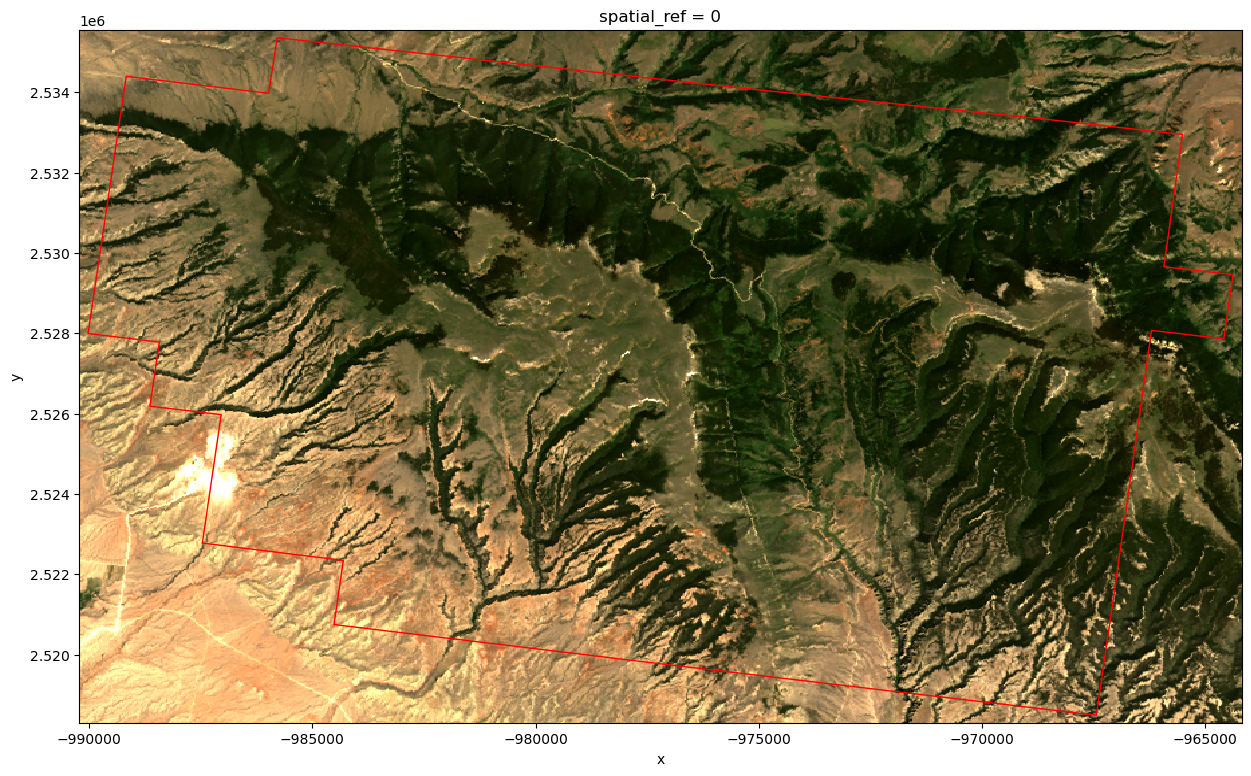

In [14]:
p=nf1p.plot(edgecolor='red',facecolor='none',figsize=(15,9))
p=ls30s.get_bands([1,2,3]).xdata.plot.imshow(ax=p,robust=True)

p

## Create definitions to sample the data, generate weights, and perform convolution analysis.

In [18]:
from raster_tools import creation,focal
from sklearn.preprocessing import MinMaxScaler
import numba as nb

@nb.jit(nopython=True, nogil=True)
def _conv_pca(x,cmp_, m_, size):
    '''
    Performs the convolution given a array, component scores, means, and kernel size using dask's map_overlap function
    x=(numpy array) of data
    cmp_= (numpy array) component scores from sklearn PCA procedure
    m_= (numpy array) mean values from sklearn PCA procedure
    size= (int) width of the kernel

    returns a numpy array of correct shape for PCA transformation
    '''
    bnd,rws,clms=x.shape
    hs=int(size/2)
    outarr=np.empty((cmp_.shape[0],rws,clms))
    for ri in range(hs,rws-hs):
        sr=ri-hs
        for ci in range(hs,clms-hs):
            sc=ci-hs
            vls=x[:,sr:sr+size,sc:sc+size].flatten()
            for b in range(cmp_.shape[0]):
                vls2=((vls-m_)*cmp_[b,:]).sum() #remove the centering piece in standard scaler it is done here
                outarr[b,ri,ci]=vls2
    
    return outarr

@nb.jit(nopython=True, nogil=True)
def _expand_for_kernel(isys,isxs,wsize,mr,mc):
    '''
    Extracts values for kernel cells. Cells indices falling on the boundary of the image are moved in one index value. 
    isys=array of row index locations
    isxs=array of column index locations
    wsize=width of the kernel
    mr=max row index
    mc=max column index

    returns two new lists of index values that can be used to extract coordinate from an xarray data array
    '''
    hw=int(wsize/2)
    isys2=np.zeros(isys.shape[0]*wsize,dtype='int32')
    isxs2=np.zeros(isxs.shape[0]*wsize,dtype='int32')
    for r in range(isys.shape[0]):
        cvl=isys[r]
        cvlm=cvl-hw
        for r2 in range(wsize):
            nr=r2+r*wsize
            nvl=cvlm+r2
            if(nvl>=mr):
                nvl=mr-1
            
            isys2[nr]=nvl

    for c in range(isxs.shape[0]):
        cvl=isxs[c]
        cvlm=cvl-hw
        for c2 in range(wsize):
            nc=c2+c*wsize
            nvl=cvlm+c2
            if(nvl>=mc):
                nvl=mc-1

            isxs2[nc]=nvl

    return isys2,isxs2 

def _sys_sample_image(rs,p,wsize=0):
    '''
    Creates a systematic sample of an image given a percent of cells sampled.
    rs = Raster object to be sampled
    p = percent of pixels to sample
    wsize=(int) width of a square kernel in cells if using convolution type analyses

    returns a 2d array of cell values rows=point centroid columns= band values
    if using kernels columns correspond to kernel cell values for each point
    '''
    bnds,rws,clms=rs.shape
    ys=rs.y
    xs=rs.x
    sr=int(rws/(rws*p))
    sc=int(clms/(clms*p))
    rstr=int(np.random.rand()*sr)
    rstc=int(np.random.rand()*sc)
    isys=np.arange(rstr,rws,sr)
    isxs=np.arange(rstc,clms,sc)
    rws2=isys.shape[0]
    clms2=isxs.shape[0]
    if(wsize>0):
        bnds=bnds*wsize**2
        isys,isxs=_expand_for_kernel(isys,isxs,wsize,rws,clms)

    sys=ys[isys]
    sxs=xs[isxs]
    sel=rs.xdata.sel(x=sxs,y=sys)
    # lx,ly=np.meshgrid(sel.x,sel.y) #if you want to look at the location of each sampled cell
    # pnts=gpd.GeoSeries(gpd.points_from_xy(x=lx.flatten(),y=ly.flatten(),crs=rs.crs))

    return np.moveaxis(sel.values,0,-1).flatten().reshape((rws2*clms2,bnds))#, pnts, sel

def conv_pca(rs,prc=0.9,smp=0.01,ksize=0,output_bit_depth=None):
    '''
    determines convolution kernel weights for an optimal raster projection and returns a transformed raster
    using those weights. Weights are derived from a PCA analysis of each kernel cell value. Kernel cell
    values are extracted for each band in the rs stack.

    rs=(Raster) input raster object
    wsize=(int) window diameter for a square kernel measured in cells 
    prc=(float) the proportion of variation in the data kept in the final raster dataset (0-1)
    smp=(float) the proportion of data used to build the transformation (training data - systematic random sample of location)
    ksize=(int) kernel width to use measured in cells
    output_bit_depths=(int) optional parameter used to scale the analysis outputs to a specified bit depth (e.g., 8,16,32).
    By default (None) output values will not be scaled

    returns a projected raster object and the pca object
    '''
    #scale values using a sample
    vls=_sys_sample_image(rs,p=smp)
    ss=StandardScaler(with_mean=False)
    ss.fit(vls)
    
    #apply the scaling to the input raster
    ss_mdl = general.ModelPredictAdaptor(ss,'transform')
    nch=(rs.nbands,*rs.xdata.chunks[1:])
    sc_pred_rs=rs.model_predict(ss_mdl,rs.nbands).chunk(nch)

    #perform pca using a sample of the scaled raster values
    vls2=_sys_sample_image(sc_pred_rs,p=smp,wsize=ksize)
    pca=PCA()
    pca.fit(vls2)
    #determine number of components to use
    ev=pca.explained_variance_ratio_
    sev=0
    for i in range(ev.shape[0]):
        e=ev[i]
        sev+=e
        if sev>prc:
            break
    kc=i+1 #add one to address 0 start

    #extract component scores for _conv_pca method
    kdf=pca.components_[0:kc,:] #scores,component (rows have weightings)
    hw=int(ksize/2)

    #apply _conv_pca to map_overlap function
    darr=sc_pred_rs.data.map_overlap(
        _conv_pca,
        depth={0: 0, 1: hw, 2: hw},
        chunks=((kdf.shape[0],),*sc_pred_rs.data.chunks[1:]),
        boundary=np.nan,
        dtype='f8',
        meta=np.array((),dtype='f8'),
        cmp_=kdf, 
        m_=pca.mean_, 
        size=ksize
    )
    #convert dask array back to a raster
    cmp_rs=data_to_raster(darr,x=sc_pred_rs.x,y=sc_pred_rs.y,affine=sc_pred_rs.affine,crs=sc_pred_rs.crs,nv=sc_pred_rs.null_value)

    #scale projected raster to bit depth if specified
    if(not output_bit_depth is None):
        pcasvls=pca.transform(vls2)[:,0:kc]
        mmsc=MinMaxScaler()
        mmsc.fit(pcasvls)
        mmsc_mdl=general.ModelPredictAdaptor(mmsc,'transform')
        cmp_rs=(cmp_rs.model_predict(mmsc_mdl,cmp_rs.nbands)*(2**output_bit_depth-1)).astype('uint'+str(output_bit_depth))
    
    return cmp_rs,pca


#perform the pca convolution process on the landsat image; kernel size 5 by 5, output bit depth 16.
# This can be any size kernel. I have tried up to a 15 by 15.
conv_rs,pca=conv_pca(ls30s,prc=0.95,smp=0.10,ksize=5,output_bit_depth=16)   

c:\Users\jshogland\AppData\Local\miniconda3\envs\rstools\lib\site-packages\raster_tools\raster.py:1689: UserWarning: The null value -999999.0 could not be cast to uint16. It has been automatically changed to 9999
  nv = reconcile_nullvalue_with_dtype(


### Visualize % variation explained in each band of the transformed image.
#### The number of bands corresponds to the number of components that account for 95% of the variation in the 5 by 5 convolved image. Note that most of the variation/information in the data is explained in the first 6 components

None

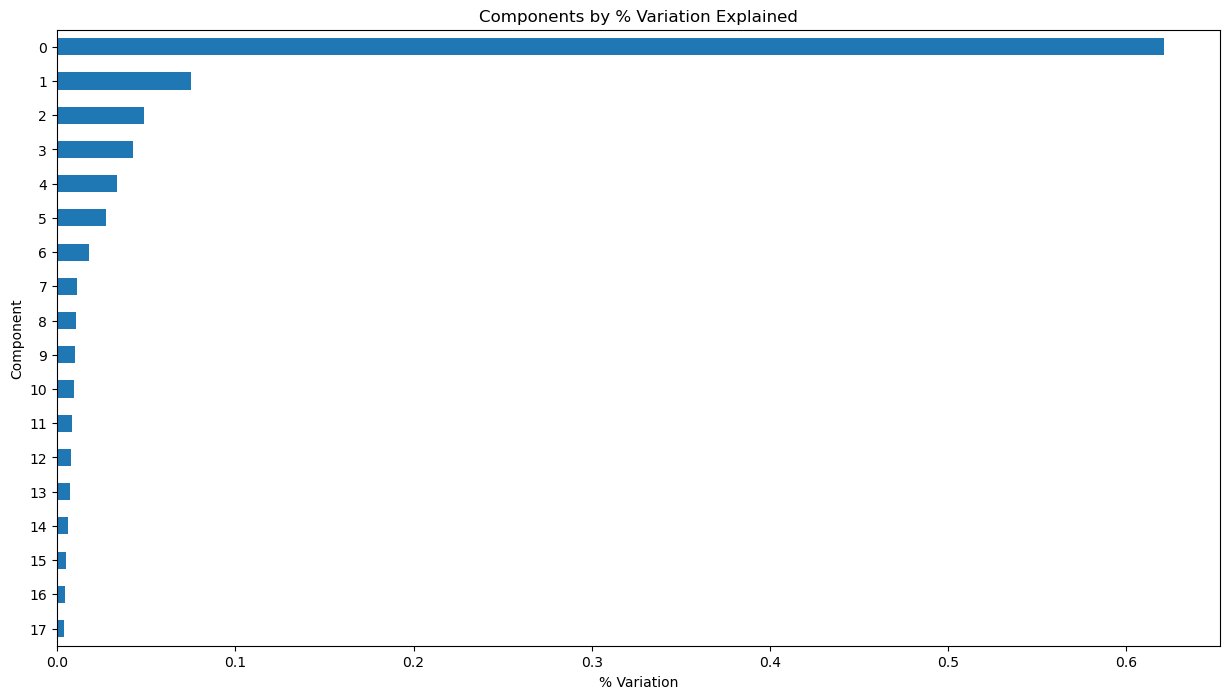

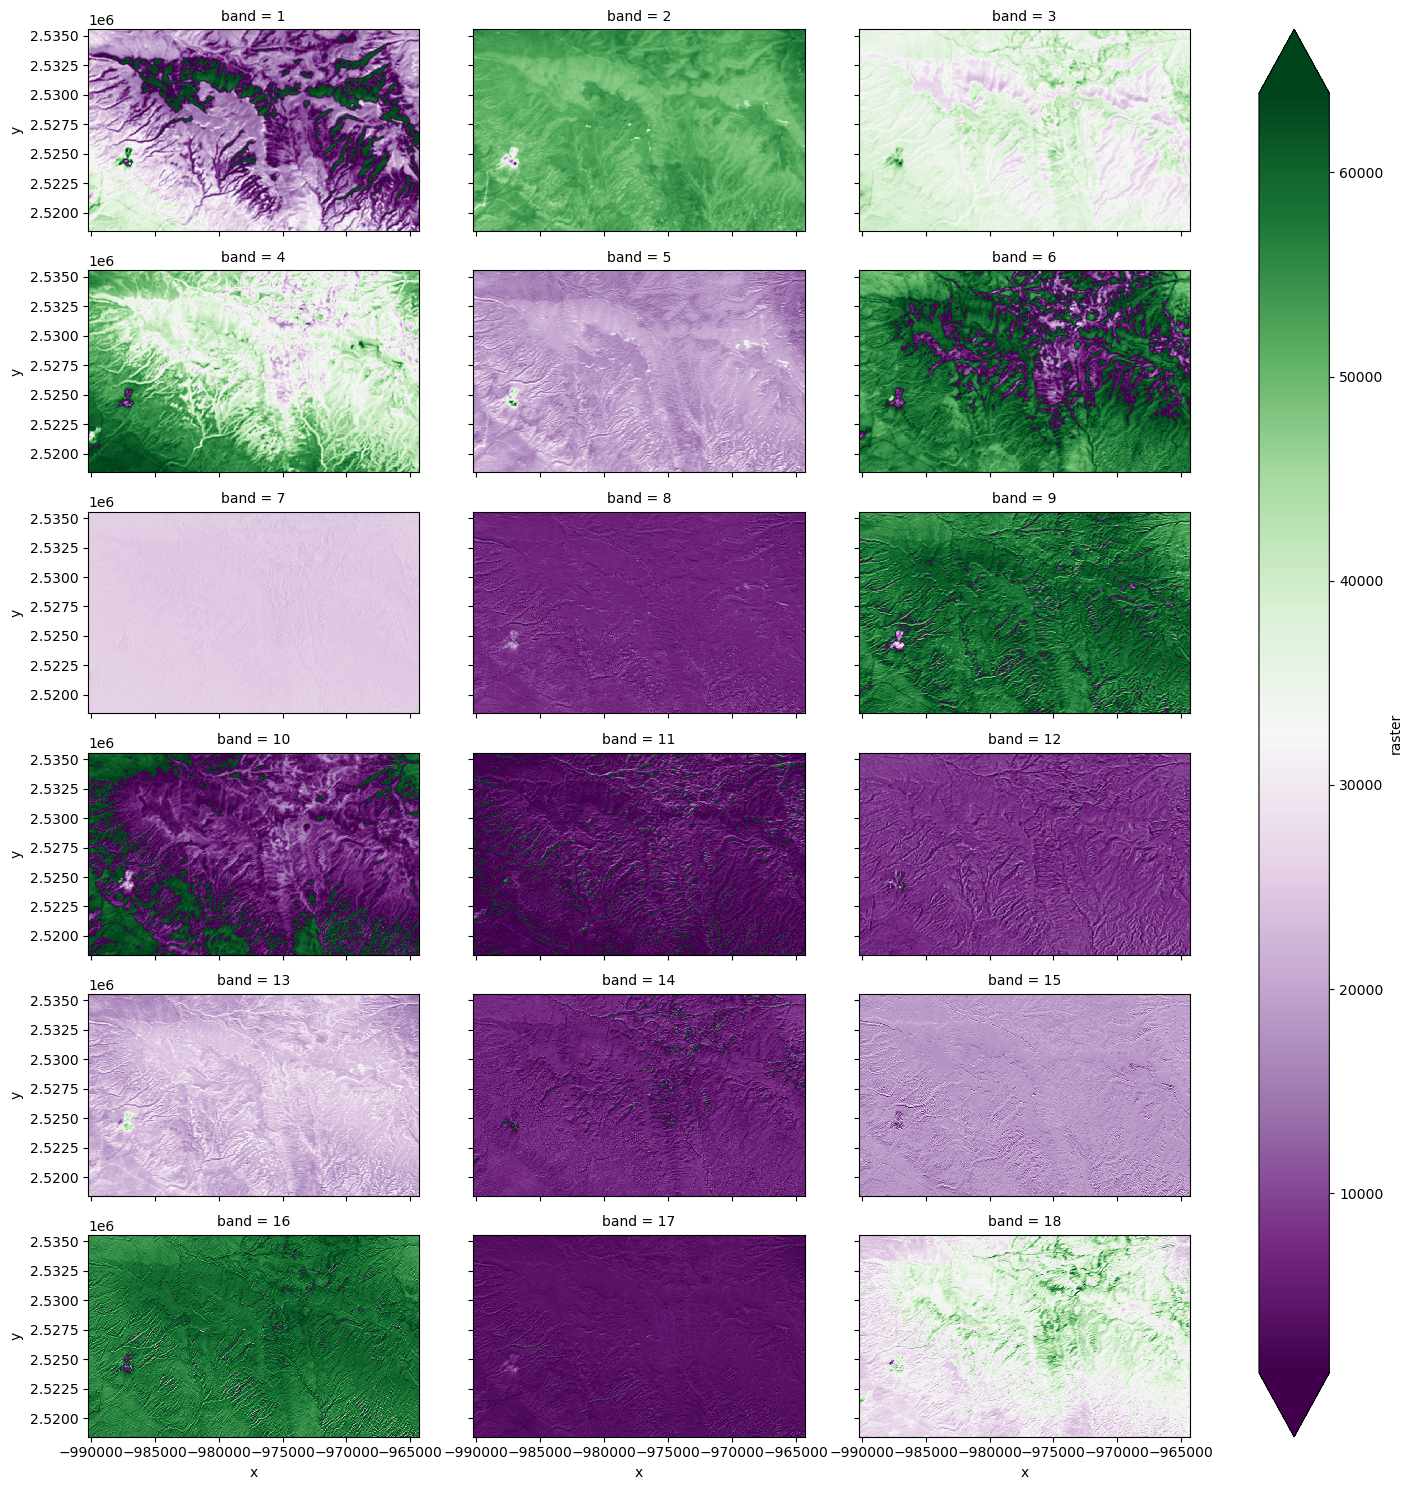

In [32]:
var_exp=pd.DataFrame(pca.explained_variance_ratio_[:18])
p=var_exp.plot(kind='barh',title='Components by % Variation Explained', xlabel='% Variation', ylabel='Component', figsize=(15,8),legend=False).invert_yaxis()
display(p)
conv_rs.plot(x='x',y='y',col='band',col_wrap=3,figsize=(15,15),robust=True,cmap='PRGn')

## Conclusion
### This approach to estimating weights for each convolution kernel and then further using those weights to convolve an image (raster stack) appears to do a good job of highlighting various features in the image, is quick, and mathematically determines kernel weights such that each band in the output convolved image is independent of the other bands values. Moreover, the process removes all redundant information across bands and within kernel cell values, which is also desirable. These surfaces should make for good predictor variables and should make it easy to spread and balance a sample across all the information in a convolved image.  